# Fig6b - Peptide and Gene interaction map

In [265]:

### Following part 1, this pipeline is part 2 and identifies the interprotein motifs among the significantly enriched motif set  
### Then forms interaction maps for the significant motifs 

import re 
import ast
from collections import defaultdict
import networkx as nx
import pandas as pd 


file1 = "Motif_NOWILDCARD_MHcorrected_significant_motifs_FDR_E_3.txt" ## this is the file output from part 1 of the pipeline 
file2 = 'HITS_Round2_Pfonly_250kfil_techclean_3zscorefil_5patientsfil_allhits_sequences_9227.fa'
peptide_outfile = file1.split(".txt")[0] + file1.split("/")[-2].split("minmotif")[1] +'NO_SELF_Interactions_PEPTIDE_NETWORK.gml'
gene_outfile = file1.split(".txt")[0] + file1.split("/")[-2].split("minmotif")[1]  + 'NO_SELF_Interactions_GENE_NETWORK.gml'


f100 = open(file1,'r')

f100.readline() ## rread the header line 


significant_motif_pep = defaultdict(list)

for line in f100:
    motif = line.split("\t")[0]
    pep = ast.literal_eval(line.split("\t")[1])
    significant_motif_pep[motif] = pep
    
f100.close()



### classifying peptides into genes. 


f = open(file2,'r')

gene_details = {} ## tuple of (gene name, product)

i = 0
for line in f: 
    name = line.lstrip(">")
    name = name.strip("\n")
    name = name.replace('|',':')

    if re.search(r'rifin|RIFIN|Rifin',name): 
        gene = name.split(":")[0] 
        product = 'rifin'
   
    elif re.search(r'PfEMP1|PFEMP1|pfemp1|erythrocyte_membrane_protein_1',name):
        gene = name.split(":")[0] 
        product = 'var'

    elif re.search(r'stevor|Stevor|STEVOR', name):
        gene = name.split(":")[0] 
        product = 'Stevor'

    elif re.search(r'SURFIN|surfin|Surfin',name):
        gene = name.split(":")[0] 
        product = 'Surfin'

    elif re.search(r'Pfmc-2TM|pfmc-2TM',  name):
        gene = name.split(":")[0] 
        product = 'Pfmc-2TM'

    elif 'AMA1' in name:
        gene = 'AMA1'
        product = 'AMA1'

    elif 'MSP1' in name:
        gene = 'MSP1'
        product = 'MSP1'

    elif 'MSPDBL1' in name:
        gene = 'MSPDBL1'
        product = 'MSPDBL1'

    elif 'MSPDBL2' in name:
        gene = 'MSPDBL2'
        product = 'MSPDBL2'
        
    elif re.search(r'^ano', name):
        gene = 'anopheles'
        product = 'anopheles protein'

    elif re.search(r'erythrocyte_binding_antigen-175', name):
        gene = 'EBA-175'
        product = 'EBA-175'

    elif re.search(r'erythrocyte_binding_antigen-140', name):
        gene = 'EBA-140'
        product = 'EBA-140'

    elif re.search(r'Circumsporozoite_protein|circumsporozoite_protein|PF3D7_0304600', name):
        gene = 'circumsporozoite_(CS)_protein'
        product = 'circumsporozoite_(CS)_protein'

    elif ':' in name:
        try:
            gene = name.split(":")[0] 
            product = name.split(":")[4].split("=")[1]
            if (('unknown' in product) | ('putative' in product) | ('EMP1-trafficking' in product)| ('AP2_domain' in product)| ('MSP7-like_protein' in product)| ('acyl-CoA_synthetase' in product)):
                product = gene + product
            else:
                product = gene + product


        except:
            print (name)

    elif 'var' in name:
        gene = name.split('_seq')[0]
        product = 'var'

    else: 
        gene = name.split('_seq')[0]  ### pretty much all ofo the remaining ones without an annotation or a 'var' term are all var
        product = 'var'

    gene_details[name] = (gene,product)
    next(f)    
    i = i+1
f.close()


### consider only unique IT orthologs and remove other ITs which have 3D7 representation in the library 
## some IT orthologs of 3D7 still remain because of some issues in PlasmoDB in not calling these as orthologs 

missedorthologs = ['PFIT_0304500','PFIT_1037600','PFIT_0201200','PFIT_0701200','PFIT_0422900','PFIT_0112400','PFIT_1149200','PFIT_0511600','PFIT_0703000','PFIT_0722000','PFIT_1141400','PFIT_1411300','PFIT_0406400','PFIT_0100700','PFIT_0830700','PFIT_0406400','PFIT_0400600','PFIT_0318200','PFIT_0310100','PFIT_0200900','PFIT_1001600','PFIT_0100700']
f = open('Hits_zscore_3_cmin5_alluniquegenehits_nonVSA.txt','r')
unique = set()
for line in f:
    unique.add(line.strip('\n'))
print (len(unique))
spl = ['var','rifin','Stevor','Surfin','Pfmc-2TM','AMA1','MSP1','anopheles protein','MSPDB','EBA-175','EBA-140','circumsporozoite_(CS)_protein']
for k in gene_details:
    gene = gene_details[k][0]
    product = gene_details[k][1]
    if product not in spl: 
        if ((gene.split('.1-p1')[0] not in unique)|(gene.split('.1-p1')[0] in missedorthologs)):
            gene_details[k] = ('remove','remove') ## tagging the peptide for removal from analysis 

### form interaction network of peptides and genes 

fh1 = open(file2,'r')
lines=fh1.readlines()

from itertools import combinations 

dict_Slimsearch_network_peptides = defaultdict(set)
dict_Slimsearch_network_genes = defaultdict(set)
gene_list = set()
motif_list = set()
inter_protein_motifs = dict()
gene_interactors = defaultdict(set)
for motif in significant_motif_pep:
    
    peptides = set()
    if '|' in motif:
        string = motif.split("|")
        minlen = min([len(i) for i in string])


    else:
        minlen = len(motif)

    if (minlen >= 6):
        
        pep = significant_motif_pep[motif]

        for number in pep:
            no = int(number)*2

            peptide = lines[no].strip("\n")
            peptide = peptide.lstrip(">")
            peptide = peptide.replace('|', ':')
            ### remove orthologs from IT being already represented by 3D7  
            if gene_details[peptide][0]!= 'remove': ## add only if the peptide is coming from a unique IT protein 
                peptides.add(peptide)

        if len(peptides) > 1:
            pairwise = list(combinations(peptides, 2)) 

            for x in (pairwise):
                gene1 = gene_details[x[0]][1]
                gene2 = gene_details[x[1]][1]
                gene_list.add(gene_details[x[0]][0])
                gene_list.add(gene_details[x[1]][0])
                
                if (gene1 != gene2):  ### DO NOT INCLUDE self interactions 
                    motif_list.add(motif)
                    genes= sorted([gene1,gene2])
                    dict_Slimsearch_network_peptides[x].add(motif)
                    dict_Slimsearch_network_genes[(genes[0],genes[1])].add(motif)
                    ## add each other as interactors for this pair of genes 
                    gene_interactors[gene1].add(gene2) 
                    gene_interactors[gene2].add(gene1)
                    inter_protein_motifs[motif] = peptides


fh1.close()


### 4. Create a network file to run on cytoscape  

## Peptide file 

weights = [(k[0],k[1],len(v)) for k,v in dict_Slimsearch_network_peptides.items()]
G = nx.Graph()   
G.add_weighted_edges_from(weights)
nx.write_gml(G, peptide_outfile)

## Gene file 

weights = [(k[0],k[1],len(v)) for k,v in dict_Slimsearch_network_genes.items()]
G = nx.Graph()   
G.add_weighted_edges_from(weights)
nx.write_gml(G, gene_outfile)

# ### write a gene attribute file with seroprevalance and number of interactors  

f16 = open(file1.split('.txt')[0]+ file1.split("/")[-2].split("minmotif")[1] +'Cytoscape_gene_attributes_HITS_interactors.txt','w')
# f16 = open(file1.split('.txt')[0]+ 'Cytoscape_gene_attributes_HITS_interactors.txt','w')
f16.write('gene'+'\t' +'seroprevalance'+ '\t'+ 'gene_interactors' + '\t' + '# interactors' + "\n")


z_hit_8 = pd.read_csv('HITS_Round2_Pfonly_250kfil_techclean_3zscorefil_5patientsfil.csv',header=0,index_col = 'peptide')
z_hit_8 =   z_hit_8.filter(regex='CK3|CT3',axis=1)  
z_hit_8_strreplaced = z_hit_8
z_hit_8_strreplaced.index = z_hit_8_strreplaced.index.str.replace('|', ':')


### Add seroprevalance values. This is calculated by asking how many people react to any of the peptides within a protein 

seroprevalence = {}
for gene in gene_interactors.keys():
        
    no_interactors = len(gene_interactors[gene])
    interactors = gene_interactors[gene]
       
    pep = z_hit_8.loc[[g for g,v in gene_details.items() if v[1] == gene]]
    person_total = pep.sum(axis=0)
    sero = person_total[person_total>0] ## any person with reactivity to more than 1 peptide is counted 
    seroprevalence[gene] = sero.shape[0]
    f16.write(gene + '\t' + str(sero.shape[0]) + '\t' + str(interactors) + '\t' + str(no_interactors) + '\n')
f16.close()




### Create a file with all the genes sharing motifs and the motifs shared between them 

f101 = open(file1.split('.txt')[0]+ file1.split("/")[-2].split("minmotif")[1] +'gene_interactors_with_motifs.txt','w')
#f101 = open(file1.split('.txt')[0]+'gene_interactors_with_motifs.txt','w')

for k,v in dict_Slimsearch_network_genes.items():
    f101.write(k[0]+'\t'+ k[1] + '\t' + str(v) + '\n')

f101.close()

### Create a file with all the motifs

f102 = open(file1.split('.txt')[0]+ file1.split("/")[-2].split("minmotif")[1] +'_interproteinmotifs.txt','w')
#f102 = open(file1.split('.txt')[0] +'_interproteinmotifs.txt','w')

for k,v in inter_protein_motifs.items():
    f102.write(k + '\t' + str(v) + '\n')

f102.close()

## Create a file with only motifs shared by genes with >30% sero 

f101 = open(file1.split('.txt')[0]+ file1.split("/")[-2].split("minmotif")[1] +'_Over30sero_gene_interactors_with_motifs.txt','w')
    
for k,v in dict_Slimsearch_network_genes.items():
    if (seroprevalence[k[0]] >= 60) & (seroprevalence[k[1]] >= 60): 
        f101.write(k[0]+'\t'+ k[1] + '\t' + str(v) + '\n')
f101.close()  


sero_gene = {}
genes = set([v[1] for k,v in gene_details.items()])
for gene in genes:
    pep = z_hit_8.loc[[g1 for g1,v1 in gene_details.items() if v1[1] == gene]]
    person_total = pep.sum(axis=0)
    sero = person_total[person_total>0]
    sero_gene[gene] = sero.shape[0]
    

sero_over30 = set([k for k,v in sero_gene.items() if v>=60])
sero_10_30 = set([k for k,v in sero_gene.items() if (v>=20)&(v<60)])
sero_5_10 = set([k for k,v in sero_gene.items() if (v>=10)&(v<20)])
sero_2_5 = set([k for k,v in sero_gene.items() if (v>=5)&(v<10)])

print ("The number of proteins sharing is " + str(len(gene_interactors.keys())))
print ("The number of inter-protein motifs is " + str(len(motif_list)))   

print ("Number of genes over sero30 " + str(len(sero_over30)) + " and of with inter-protein motifs are " + str(len(sero_over30.intersection(set(gene_interactors.keys())))))
print ("Number of genes sero 10-30 " + str(len(sero_10_30)) + " and of with inter-protein motifs are " + str(len(sero_10_30.intersection(set(gene_interactors.keys())))))
print ("Number of genes sero 5-10 " +str(len(sero_5_10))+ " and of with inter-protein motifs are " + str(len(sero_5_10.intersection(set(gene_interactors.keys())))))
print ("Number of genes sero 2.5-5 " +str(len(sero_2_5))+ " and of with inter-protein motifs are " + str(len(sero_2_5.intersection(set(gene_interactors.keys())))))




1648
The number of proteins sharing is 509
The number of inter-protein motifs is 911
Number of genes over sero30 64 and of with inter-protein motifs are 51
Number of genes sero 10-30 354 and of with inter-protein motifs are 208
Number of genes sero 5-10 510 and of with inter-protein motifs are 163
Number of genes sero 2.5-5 701 and of with inter-protein motifs are 87


# Fig 6-Supplement 1 

There is a total of 1105 sequences
The first peptide sequence is: IEKQVEE
911
The number of peptides with properties calculated is: 1105
There is a total of 1105 sequences
The first peptide sequence is: MIICNNN
The number of peptides with properties calculated is: 1105


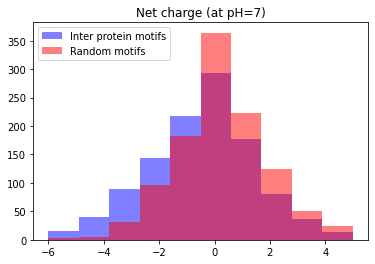

KstestResult(statistic=0.17828054298642534, pvalue=9.40208571666974e-16)


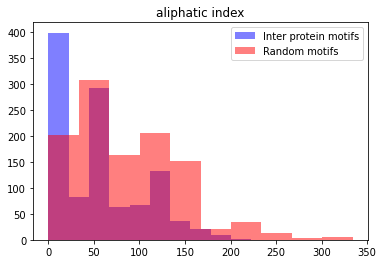

KstestResult(statistic=0.24705882352941178, pvalue=5.215631297257783e-30)


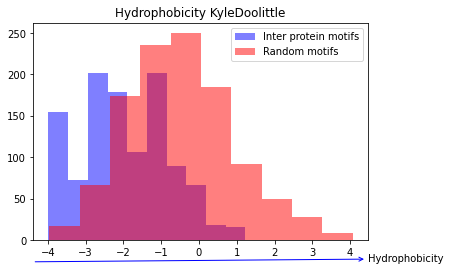

KstestResult(statistic=0.41990950226244345, pvalue=1.1101375221385672e-87)


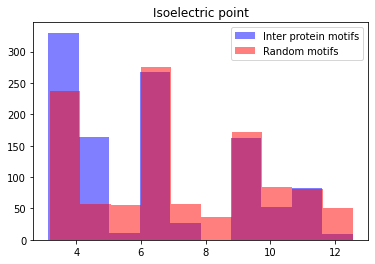

KstestResult(statistic=0.18099547511312217, pvalue=3.163829132480797e-16)


In [113]:

import peptides
import numpy as np 
from matplotlib import pyplot as plt 

f2 = open('Motif_NOWILDCARD_MHcorrected_significant_motifs_FDR_E_3len_7_identity5aa_wildcardno_interproteinmotifs.txt','r')
a = list()
intermotifs = set()

for line in f2:
    motif = line.split('\t')[0].strip('\n')
    a.append(motif)
    for item in motif.split('|'):
        intermotifs.add(item)

f2.close()
sequences=list(intermotifs)

print("There is a total of {} sequences".format(len(sequences)))
print("The first peptide sequence is: {}".format(sequences[0]))
print (len(a))

# List with the properties
charges=[]
aliphatic=[]
hydrophobic=[]
isoelctricpoint=[]

# Loop over the sequences
for seq in sequences:
    
    peptide = peptides.Peptide(seq) # Create the object and run the calculations
    charges.append(peptide.charge(pH=7.4))
    aliphatic.append(peptide.aliphatic_index())
    isoelctricpoint.append(peptide.isoelectric_point())
    hydrophobic.append(peptide.hydrophobicity('KyteDoolittle'))

print("The number of peptides with properties calculated is: {}".format(len(charges)))

chargesData=np.array(charges).astype(np.float)
aliphaticData=np.array(aliphatic).astype(np.float)
hydrophobicData=np.array(hydrophobic).astype(np.float)
isoelctricpointData=np.array(isoelctricpoint).astype(np.float)


# Random set of kmers and their properties from the whole proteome 


prot_kmer = set()

for line in proteome:
    line2 = next(proteome)
    seq = line2.strip("\n")
    for i in range(0,56):
        kmer = seq[i:i+7]
        prot_kmer.add(kmer)
proteome.close()


# randomly sample 1105 kmers and plot the distribution
import random
randommker = random.sample(list(prot_kmer),1105)

sequences=list(randommker)

print("There is a total of {} sequences".format(len(sequences)))
print("The first peptide sequence is: {}".format(sequences[0]))

# List with the properties
charges=[]
aliphatic=[]
hydrophobic=[]
isoelctricpoint=[]

# Loop over the sequences
for seq in sequences:
    
    peptide = peptides.Peptide(seq) # Create the object and run the calculations
    charges.append(peptide.charge(pH=7.4))
    aliphatic.append(peptide.aliphatic_index())
    isoelctricpoint.append(peptide.isoelectric_point())
    hydrophobic.append(peptide.hydrophobicity('KyteDoolittle'))

print("The number of peptides with properties calculated is: {}".format(len(charges)))

chargesData_random=np.array(charges).astype(np.float)
aliphaticData_random=np.array(aliphatic).astype(np.float)
hydrophobicData_random=np.array(hydrophobic).astype(np.float)
isoelctricpointData_random=np.array(isoelctricpoint).astype(np.float)


from scipy import stats


fig,ax = plt.subplots()
ax.hist(chargesData, alpha=0.5, color='b', linewidth=0,label='Inter protein motifs' )
ax.hist(chargesData_random, alpha=0.5, color='r', linewidth=0, label='Random motifs')
plt.title('Net charge (at pH=7)')
ax.legend()
plt.savefig('FigS6a_Interproteinmotifs_charge.pdf',dpi=800)
plt.show()
print (stats.ks_2samp(chargesData,chargesData_random))

fig,ax = plt.subplots()
ax.hist(aliphaticData,  alpha=0.5, color='b', linewidth=0,label='Inter protein motifs')
ax.hist(aliphaticData_random,  alpha=0.5, color='r', linewidth=0,label='Random motifs')
plt.title('aliphatic index')
ax.legend()
plt.show()
print (scipy.stats.ks_2samp(aliphaticData,aliphaticData_random))


fig,ax = plt.subplots()
ax.hist(hydrophobicData, alpha=0.5, color='b', linewidth=0,label='Inter protein motifs')
ax.hist(hydrophobicData_random, alpha=0.5, color='r', linewidth=0,label='Random motifs')
plt.title('Hydrophobicity KyleDoolittle')
ax.legend()
ax.annotate('Hydrophobicity', xy=(0, -0.1), xycoords='axes fraction', xytext=(1, -0.1), 
            arrowprops=dict(arrowstyle="<-", color='b'))
plt.savefig('FigS6a_Interproteinmotifs_hydrophobicity.pdf',dpi=800)
plt.show()
print (scipy.stats.ks_2samp(hydrophobicData,hydrophobicData_random))


fig,ax = plt.subplots()
ax.hist(isoelctricpointData,color='b',alpha=0.5,  linewidth=0,label='Inter protein motifs')
ax.hist(isoelctricpointData_random,color='r',alpha=0.5,  linewidth=0,label='Random motifs')
plt.title('Isoelectric point')
ax.legend()
plt.show()
print (scipy.stats.ks_2samp(isoelctricpointData,isoelctricpointData_random))


In [1016]:
chargesData.mean()


-0.46874033205879734

In [918]:
chargesData_random.mean()

0.17720237718644782

In [1017]:

hydrophobicData.mean()

-1.9532255979314803

In [1018]:
hydrophobicData_random.mean()

-0.46892049127343244

There is a total of 879 sequences
The first peptide sequence is: IEKQVEE
911


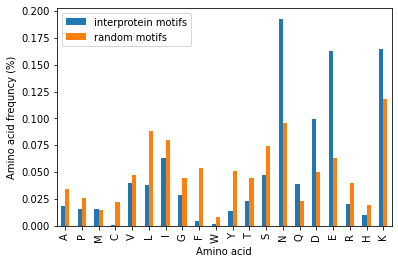

In [1006]:

import peptides
f2 = open('Motif_NOWILDCARD_MHcorrected_significant_motifs_FDR_E_3len_7_identity5aa_wildcardno_interproteinmotifs.txt','r')
a = list()
intermotifs = set()

for line in f2:
    motif = line.split('\t')[0].strip('\n')
    a.append(motif)
    for item in motif.split('|'): 
        intermotifs.add(item)
        break ## add only one from the list to avoid redundancy 
        
f2.close()
sequences=list(intermotifs)

print("There is a total of {} sequences".format(len(sequences)))
print("The first peptide sequence is: {}".format(sequences[0]))
print (len(a))

# Amino acid freq distribution 

totalseq = ''
# Loop over the sequences
for seq in sequences:
    totalseq = seq + totalseq
    
peptide = peptides.Peptide(totalseq) # Create the object and run the calculations
intermotiffreq = {k:v for k,v in peptide.frequencies().items()}

# Random set of kmers and their properties from the whole proteome 

proteome = open("PFpeptides.fasta","r") ## Get the 3D7 proteome seq fasta file for this step

prot_kmer = set()

for line in proteome:
    line2 = next(proteome)
    seq = line2.strip("\n")
    for i in range(0,56):
        kmer = seq[i:i+7]
        prot_kmer.add(kmer)
proteome.close()


# randomly sample 1105 kmers and plot the distribution
import random

df_boot = pd.DataFrame()

for i in range(0,1000):

    randommker = random.sample(list(prot_kmer),879)

    sequences=list(randommker)

#     print("There is a total of {} sequences".format(len(sequences)))
#     print("The first peptide sequence is: {}".format(sequences[0]))

    randomseq = ''
    # Loop over the sequences
    for seq in sequences:
        randomseq = seq + randomseq

    peptide = peptides.Peptide(randomseq) # Create the object and run the calculations
    randomfreq = {k:v for k,v in peptide.frequencies().items()}

    df_boot =  df_boot.append(randomfreq, ignore_index=True)
    

randommean = df_boot.mean(axis=0)
randomstd = df_boot.std(axis=0)

df_freq = pd.DataFrame.from_dict([intermotiffreq,randomfreq]).T
df_freq.columns = ['interprotein motifs','random motifs']
df_freq['interprotein motifs'] = df_freq['interprotein motifs']
df_freq['random motifs'] = df_freq['random motifs']
df_freq = df_freq.drop(['O','U','B','Z','J','X'],axis=0)
df_freq = df_freq.reindex(['A','P','M','C','V','L','I','G','F','W','Y','T','S','N','Q','D','E','R','H','K'])
df_freq.plot.bar()
plt.ylabel('Amino acid frequncy (%)')
plt.xlabel('Amino acid')
plt.savefig('FigS6a_interproteinmotifs_aminoacidfreq.pdf',dpi=400)

zscore = (df_freq.T - randommean)/randomstd


# Fig6-Supplement 2

In [ ]:
# Goal is to look at peptides overlapping a peptide containing a significantly enriched motif to get 
# an idea on how significant the motif is to that peeptide enrichment
# If the surrounding peptides lack the motif and show a decrease in enrichment, then it is likeelly that the motif 
# is part of the reactive sequence 
# In conrast, if the motif is present in certain peeptides, but still not enriched, then that indicates that the 
# enrichment involves more things and not just the motif 

# This is the pipeline that will be used

# For each motif, collect all hit peptides that have the motif 
# Then for each hit peptide in that group, select + and - 2 neighboring peptides (because of the overlap - there will be two peptides on each side overlapping a given peptide)
# Collect this set of peptides for that motif 
# Then go through rpk for each person and get the max rpk of this collection per person 
# Then calculate the rpk fraction for each peptide in that group as a function of the max rpk 
# Also classify the peptides into motif containing or not 
# Then look at the mean fraction of all people for those with and without the motif and see if there is a difference in distributions 



In [ ]:
file1 = "Motif_NOWILDCARD_MHcorrected_significant_motifs_FDR_E_3.txt"
file2 = 'HITS_Round2_Pfonly_250kfil_techclean_3zscorefil_5patientsfil_allhits_sequences_9227.fa'


f100 = open(file1,'r')

f100.readline() ## rread the header line 


significant_motif_pep = defaultdict(list)

for line in f100:
    motif = line.split("\t")[0]
    pep = ast.literal_eval(line.split("\t")[1])
    significant_motif_pep[motif] = pep
    
f100.close()


fh1 = open(file2,'r')
lines=fh1.readlines()


In [424]:
# First get the whole zscore file and filter for the 9927 peptides +/- 2 peptides 
# add in the sequence of the peptide as well 

z_hit_8 = pd.read_csv('HITS_Round2_Pfonly_250kfil_techclean_3zscorefil_5patientsfil.csv',header=0,index_col = 'peptide')

set_neighbors = set()
for name in list(z_hit_8.index):
    no = int(name.split('_seq')[-1])
    neighbors = (no-2,no-1,no,no+1,no+2)
    for x in neighbors:
        pep = name.split('_seq')[0]+'_seq'+str(x)
        set_neighbors.add(pep)

print (len(set_neighbors))  

colindex = set_neighbors
colindex.add('new_index') ## so that sample name is included while parsing the data 

## some overlapping peptides maybe missing from the final library beecause of CD-hit collapse on 100% identity with 
## IT/3D7 ortholog. Ignore those 

## Get the z score file --> This can be obtained from Dryad 

df_zscore = pd.read_csv('MEAN_Zscore_Round2_Pfonly_250kfil_techclean.csv',index_col=0,header=0,usecols=lambda x: x in colindex)
print (df_zscore.shape)
df_zscore =df_zscore.T



33130
(287, 30368)


In [427]:
### working with a smaller dataset with only the relevant peptides so that it is faster to process
df_zscore_neighbors = df_zscore.copy() 

df_zscore_neighbors = df_zscore_neighbors.filter(regex=r'CK3|CT3',axis=1)

## add in the sequeence of the peptide as weell 

df_zscore_neighbors['sequence'] = ''
d_seq = {}

fh109 = open('FinalPlasmodiumFalciparumPhagePeptides.v2.fa','r') # If using Whole_library_peptide_to_gene_mapping.csv from Dryad for this step, modify code accordingly  

for line in fh109: 
    name = line.strip('\n').lstrip('>')
    name = name.replace(',','_')
    seq= next(fh109)
    d_seq[name] = seq 
fh109.close()
for x in df_zscore_neighbors.index: 
    df_zscore_neighbors.loc[x,'sequence'] = d_seq[x]
    
df_zscore_neighbors.index = df_zscore_neighbors.index.str.replace('|', ':')

print (df_zscore_neighbors.shape) 

(30368, 200)


In [ ]:
# Heatmap of MAXIMUM seroprevalence with and without motifs among neighboring peptides for INTERPROTEIN MOTIFS 


# Go through the list of interprotein motifs and get the peptides in each one 
# Collect the neighboring peptides for that set 
# Collect all consecutive peptide groups for each motif 
# Within each group, Classify into those with and without motif 
# Get the max sero from those with motif within the group 
# Get the max sero from those with no motif within the group that also doesn't have any other significant motifs 
# Plot the max sero with motif and max sero without motif for all groups for all motifs as a heatmap 

heatdf = pd.DataFrame(columns=['seroyes','serono'])

# collect all peptides sharing significant motifs 


y = set()
for val in significant_motif_pep.values():

    for no in val:
        y.add(int(no))
        
all_motif_pep = []    
for number in y:
        no = int(number)*2

        peptide = lines[no].strip("\n")
        peptide = peptide.lstrip(">")
        peptide = peptide.replace('|', ':')
        all_motif_pep.append(peptide)


## collect all the peptides with each motif and invstigate groups within that 

for motif in interprotienmotifs.keys():

    
    y = significant_motif_pep[motif] ## collect all the peptides with the motif 
    pep = list()
    for number in y:
            no = int(number)*2

            peptide = lines[no].strip("\n")
            peptide = peptide.lstrip(">")
            peptide = peptide.replace('|', ':')
            pep.append(peptide)

    

    ### get alll neighbors for the hit peptides with the motif 
    
    neigh = set()

    for name in pep:

        no = int(name.split('_seq')[-1])
        neighbors = (no-2,no-1,no,no+1,no+2) ### get positions of +/-2 neighbors 
        for x in neighbors:
            pepname = name.split('_seq')[0]+'_seq'+str(x) 
            
            neigh.add(pepname)
       
    ## get the consercutive groups within the neighboring set indiividually - reason to do this is to consider the context in which the motif is placed and consider differences in seroprevalences because of context 
    
    neigh = sorted(list(neigh)) # sort the list in alphabetical order 
    
    i = 0
    group_pos = [0,]
    for x in neigh:
        if i==0:
            gene = x.split('_seq')[0]
            no = int(x.split('_seq')[1])
            consec = gene+'_seq'+str(no+1)
        else:
            if x == consec: ## if this is the consecutive peptide - continue 
                gene = x.split('_seq')[0]
                no = int(x.split('_seq')[1])
                consec = gene+'_seq'+str(no+1)
            else: 
                gene = x.split('_seq')[0]
                no = int(x.split('_seq')[1])
                consec = gene+'_seq'+str(no+1)
                group_pos.append(i)  ## add the position of the peptide on the list that marks the next group
        i = i +1 
                
    # loop through different peptide groups for that motif and collect seroprevalences and add to heatmap matric 
 
    for g in range(len(group_pos)): 
        
            try:
                group_pep = neigh[group_pos[g]:group_pos[g+1]] ## get the first to last peptide within the group 
            except:
                group_pep = neigh[group_pos[g]:] ## if this is the last group , then mark it tht way  

            testdf = df_zscore_neighbors.loc[df_zscore_neighbors.index.intersection(group_pep)]

            testfrac = testdf.iloc[:,:-1]
            testfrac.where(testfrac>=3, 0, inplace=True) ## to calculate which are not hits 
            testfrac.where(testfrac<=3, 1, inplace=True) ## to calculate which are hits 

            # Get seroprevalence of the peptides 

            testfrac['sero'] = testfrac.sum(axis=1)

            # testfrac = (testfrac.sub(testfrac.loc[name])) ### divide by the zscore of the hit peptide under investigation
            testfrac['sequence'] = testdf['sequence']

            # mark whether the motif is present or not in the peptide 
            testfrac['motif'] = ''
            testfrac['motif'] = np.where(testfrac['sequence'].str.contains(fr'{motif}'),'yes','no')

            ### remove peptides without the motif that have other significant motifs --> this is to remove peptide with a variant of the current motif but is captured as no for the current motif 
            ## dirty way to remove  peptides with related interprotein motifs 
            testfrac = testfrac.drop(testfrac[testfrac['motif']=='no'].index.intersection(all_motif_pep))

            seroyes = testfrac[testfrac['motif']=='yes']['sero'].max()/2
            serono = testfrac[testfrac['motif']=='no']['sero'].max()/2

            heatdf.loc[motif+str(g)] = [seroyes,serono]
        
            

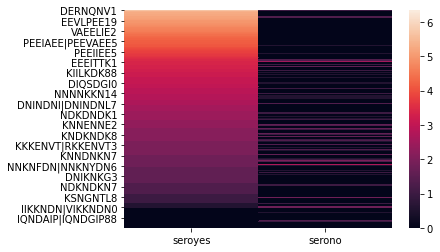

In [1020]:
to_plot = heatdf.copy()
to_plot.where(to_plot>0, 0.1, inplace=True) 

sns.heatmap(np.log2(to_plot.sort_values(by='seroyes',ascending=False)),vmin=0)


In [1022]:
(to_plot['seroyes']/to_plot['serono']).mean()

54.43969184056634

In [ ]:
# ALL SIGNIFICANT MOTIFS
# Heatmap of MAXIMUM seroprevalence with and without motifs among neighboring peptides for ALL SIGNIFICANT MOTIFS 
# Go through the list of significant motifs and get the peptides in each one 
# Collect the neighboring peptides for that set 
# Collect all consecutive peptide groups for each motif 
# Within each group, Classify into those with and without motif 
# Get the mean sero from those with motif within the group 
# Get the max sero from those with no motif within the group that also doesn't have any other significant motifs 
# Plot the mean sero with motif and max sero without motif for all groups for all motifs as a heatmap 

heatdf = pd.DataFrame(columns=['seroyes','serono'])

# collect all peptides sharing significant motifs 


y = set()
for val in significant_motif_pep.values():

    for no in val:
        y.add(int(no))
all_motif_pep = []    
for number in y:
        no = int(number)*2

        peptide = lines[no].strip("\n")
        peptide = peptide.lstrip(">")
        peptide = peptide.replace('|', ':')
        all_motif_pep.append(peptide)


## collect all the peptides with each motif and invstigate groups within that 

for motif in significant_motif_pep.keys():
#for motif in ['VAEELVE']:
    
    y = significant_motif_pep[motif] ## collect all the peptides with the motif 
    pep = list()
    for number in y:
            no = int(number)*2

            peptide = lines[no].strip("\n")
            peptide = peptide.lstrip(">")
            peptide = peptide.replace('|', ':')
            pep.append(peptide)

    

    ### get alll neighbors for the hit peptides with the motif 
    
    neigh = set()

    for name in pep:

        no = int(name.split('_seq')[-1])
        neighbors = (no-2,no-1,no,no+1,no+2) ### get positions of +/-2 neighbors 
        for x in neighbors:
            pepname = name.split('_seq')[0]+'_seq'+str(x) 
            
            neigh.add(pepname)
       
    ## get the consercutive groups within the neighboring set indiividually - reason to do this is to consider the context in which the motif is placed and consider differences in seroprevalences because of context 
    
    neigh = sorted(list(neigh)) # sort the list in alphabetical order 
    
    i = 0
    group_pos = [0,]
    for x in neigh:
        if i==0:
            gene = x.split('_seq')[0]
            no = int(x.split('_seq')[1])
            consec = gene+'_seq'+str(no+1)
        else:
            if x == consec: ## if this is the consecutive peptide - continue 
                gene = x.split('_seq')[0]
                no = int(x.split('_seq')[1])
                consec = gene+'_seq'+str(no+1)
            else: 
                gene = x.split('_seq')[0]
                no = int(x.split('_seq')[1])
                consec = gene+'_seq'+str(no+1)
                group_pos.append(i)  ## add the position of the peptide on the list that marks the next group
        i = i +1 
                
    # loop through different peptide groups for that motif and collect seroprevalences and add to heatmap matric 
 
    for g in range(len(group_pos)): 
        
            try:
                group_pep = neigh[group_pos[g]:group_pos[g+1]] ## get the first to last peptide within the group 
            except:
                group_pep = neigh[group_pos[g]:] ## if this is the last group , then mark it tht way  

            testdf = df_zscore_neighbors.loc[df_zscore_neighbors.index.intersection(group_pep)]

            testfrac = testdf.iloc[:,:-1]
            testfrac.where(testfrac>=3, 0, inplace=True) ## to calculate which are not hits 
            testfrac.where(testfrac<=3, 1, inplace=True) ## to calculate which are hits 

            # Get seroprevalence of the peptides 

            testfrac['sero'] = testfrac.sum(axis=1)

            # testfrac = (testfrac.sub(testfrac.loc[name])) ### divide by the zscore of the hit peptide under investigation
            testfrac['sequence'] = testdf['sequence']

            # mark whether the motif is present or not in the peptide 
            testfrac['motif'] = ''
            testfrac['motif'] = np.where(testfrac['sequence'].str.contains(fr'{motif}'),'yes','no')

            ### remove peptides without the motif that have other significant motifs --> this is to remove peptide with a variant of the current motif but is captured as no for the current motif 
            ## dirty way to remove  peptides with related interprotein motifs 
            testfrac = testfrac.drop(testfrac[testfrac['motif']=='no'].index.intersection(all_motif_pep))

            seroyes = testfrac[testfrac['motif']=='yes']['sero'].mean()/2
            serono = testfrac[testfrac['motif']=='no']['sero'].mean()/2

            heatdf.loc[motif+str(g)] = [seroyes,serono]
        
            

In [ ]:
heatdf.dropna(inplace=True)
heatdf.where(heatdf>0, 0.1, inplace=True) 
sns.heatmap(np.log2(heatdf.sort_values(by='seroyes',ascending=False)),vmin=0)